In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import scipy.misc, os, csv, random, math
from subprocess import check_output
import matplotlib.pyplot as plt

# Parameters

In [2]:
# AC
#trainImagePath='C:/Users/ANTHO/Desktop/TestTensorFlow/KAGGLE/Dataset/imgpp/'
#labelsPath = 'C:/Users/ANTHO/Desktop/TestTensorFlow/KAGGLE/Dataset/GT/'

# VSP
#trainImagePath='/Users/valurpalmarsson/Documents/DeepLearning/imgpp/'
#labelsPath = '/Users/valurpalmarsson/Documents/DeepLearning/GT/'

trainImagePath='./Dataset/imgpp/'
labelsPath = './Dataset/GT/'

mainPath='./Measure'

epochs=3
batchSize=10
learningRate=1e-4
numImg = 200 # Number of images to Load
shuffleData = True # Shuffle data

# Size of each subset as precentage of entire dataset
trainSize=0.6
valSize=0.2
testSize=0.2

### Create a new folder for the measures ###
path = mainPath
i=0
while os.path.exists(path):
    path = mainPath+str(i)
    i=i+1
    print(path)

os.makedirs(path)
os.makedirs(path+'/TensorBoard')
os.makedirs(path+'/SaveModel')
os.makedirs(path+'/Results')


# Extract the images & Labels

In [3]:
def importImages(nbImgStart, nbImgEnd):
    #Extract all the file in the folder
    fileNames = os.listdir(trainImagePath)
    # select a subset of files
    fileNames = fileNames[nbImgStart:nbImgEnd]
    #Extract all the image flatten and write them in an array
    
    imgs=[] # Init image list
    labels=[] # 
    for fileName in fileNames: 
        # Load images
        img = scipy.misc.imread(trainImagePath+fileName, False,'RGB')     
        img = img.ravel()#Flatten the image
        imgs.append(img)

        # Load labels
        labelName = fileName.partition('pp')[0]+'GT.csv'
        with open(labelsPath+labelName, 'r') as f:#Read the file
            reader = csv.reader(f)
            label= np.asarray(list(reader), dtype=float)#Extract the value in an array
            label = label.ravel()#flatten
            labels.append(label)#Add to the list

    imgs=np.matrix(imgs, dtype=float)/255
    labels = np.matrix(labels, dtype=float)#Convert to a matrix
    
    
    # Shuffle images to a random order, (shuffles imgs and labels in the same random order)
    combined = list(zip(imgs, labels))
    random.shuffle(combined)
    imgs[:], labels[:] = zip(*combined)

    #Size(nbImage, nbPixel)
    #print(imgs.shape)
    #print(len(imgs))
    
    return imgs, labels

# Convolutional Neural Network

In [4]:
## PARAMETERS ##
tensorBoard=True      #Save a summary?
saveVariable=True     #Save the variabe?
#retrieveSavedVariable=True #Retrieve saved variable?

# Split dataset to subsets
#imgsTrain,labelsHotTrain,imgsValidate,labelsHotValidate,imgsTest,labelsHotTest = createDatasets(imgs,labels,trainSize,valSize,testSize,shuffleData)

In [5]:
#Function

def evaluateNetwork(v_xs):
    global prediction
    y_pre = sess.run( tf.cast(prediction, tf.float32), feed_dict={xs: v_xs}) # Forward pass using v_xs as input to network
    result = np.matrix(y_pre, dtype=float)
    return result

# Calculate mean absolute error (MAE) and mean square error (MSE) for evaluation
def compute_accuracy(v_xs, v_ys):
    global prediction
    y_label = tf.reshape(v_ys, [-1, 43, 43, 1])
    y_label = tf.cast(y_label, tf.float32)
    y_pre = sess.run(prediction, feed_dict={xs: v_xs})
    y_pre = tf.cast(y_pre, tf.float32)#Force float32
    #correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
    diff = tf.subtract(tf.reduce_sum(y_label,[1,2]),tf.reduce_sum(y_pre,[1,2]))
    accuracyMAE = tf.cast(tf.reduce_mean(tf.abs(diff)),tf.float32)
    accuracyMSE = tf.cast(tf.sqrt(tf.reduce_mean(tf.square(diff))),tf.float32)
    MAE = sess.run(accuracyMAE, feed_dict={xs: v_xs, ys: v_ys})
    MSE = sess.run(accuracyMSE, feed_dict={xs: v_xs, ys: v_ys})
    
    return MAE,MSE

def weight_variable(shape, nameIn):
    initial = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(initial, name=nameIn)

def bias_variable(shape, nameIn):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=nameIn)

def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def max_pool_3x3(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,3,3,1], strides=[1,3,3,1], padding='SAME')

In [6]:
## Architecture

## Input layer ##
with tf.name_scope("Input") as scope:
    # define placeholder for inputs to network
    xs = tf.placeholder(tf.float32, [None, 256*256*3])   # 256x256x3
    ys = tf.placeholder(tf.float32, [None,43*43]) #43x43 
    x_image = tf.reshape(xs, [-1, 256, 256, 3])#[batch, in_depth, in_height, in_width, in_channels].
    y_label = tf.reshape(ys, [-1, 43, 43, 1])
    #print(x_image.shape)  # [n_samples, 28,28,1]
    
## conv1 layer ##
## maxpooling 2x2 ##
#20x (7x7)
patch=7
sizeIn=3
sizeOut=20
with tf.name_scope("Conv1") as scope:
    W_conv1 = weight_variable([patch,patch, sizeIn,sizeOut], "W_conv1")
    b_conv1 = bias_variable([sizeOut], "b_conv1")
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1) #Maxpooling 2x2, output size= inout size/2
    # Add summary ops to collect data
    w_h_conv1 = tf.summary.histogram("weightsConv1", W_conv1)
    b_h_conv1 = tf.summary.histogram("biasesConv1", b_conv1)
    
## conv2 layer ##
## maxpooling 3x3 ##
#40x (5x5)
patch=5
sizeIn=sizeOut #From previous ConvNet
sizeOut=40
with tf.name_scope("Conv2") as scope:
    W_conv2 = weight_variable([patch,patch, sizeIn,sizeOut],"W_conv2")
    b_conv2 = bias_variable([sizeOut],"b_conv2")
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_3x3(h_conv2) #Maxpooling 3x3, output size= inout size/3
    # Add summary ops to collect data
    w_h_conv2 = tf.summary.histogram("weightsConv2", W_conv2)
    b_h_conv2 = tf.summary.histogram("biasesConv2", b_conv2)
    
## conv3 layer ##
#20x (5x5)
patch=5
sizeIn=sizeOut #From previous ConvNet
sizeOut=20
with tf.name_scope("Conv3") as scope:
    W_conv3 = weight_variable([patch,patch, sizeIn,sizeOut],"W_conv3")
    b_conv3 = bias_variable([sizeOut],"b_conv3")
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    # Add summary ops to collect data
    w_h_conv3 = tf.summary.histogram("weightsConv3", W_conv3)
    b_h_conv3 = tf.summary.histogram("biasesConv3", b_conv3)
    
## conv4 layer ##
#10x (5x5)
patch=5
sizeIn=sizeOut #From previous ConvNet
sizeOut=10
with tf.name_scope("Conv4") as scope:
    W_conv4 = weight_variable([patch,patch, sizeIn,sizeOut],"W_conv4")
    b_conv4 = bias_variable([sizeOut],"b_conv4")
    h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4) + b_conv4)
    # Add summary ops to collect data
    w_h_conv4 = tf.summary.histogram("weightsConv4", W_conv4)
    b_h_conv4 = tf.summary.histogram("biasesConv4", b_conv4)
    
## conv5 layer ##
#1x (1x1)
patch=1
sizeIn=sizeOut #From previous ConvNet
sizeOut=1
with tf.name_scope("Conv5") as scope:
    W_conv5 = weight_variable([patch,patch, sizeIn,sizeOut], "W_conv5")
    b_conv5 = bias_variable([sizeOut], "b_conv5")
    h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5) + b_conv5)
    #h_conv5 = conv2d(h_conv4, W_conv5) + b_conv5
    # Add summary ops to collect data
    w_h_conv5 = tf.summary.histogram("weightsConv5", W_conv5)
    b_h_conv5 = tf.summary.histogram("biasesConv5", b_conv5)
    
   
 ## Prediction ##
with tf.name_scope("prediction") as scope:
    prediction = h_conv5
    #img_prediction = tf.summary.image("densitymap", prediction)


## Loss function ##
# the error between prediction and real data
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction),reduction_indices=[1]))# loss
with tf.name_scope("loss") as scope:
    loss = tf.reduce_mean(tf.square(tf.reduce_max(tf.subtract(prediction,y_label),[1,2])))
    #cross_entropy = tf.reshape(tf.reduce_sum(tf.square((tf.subtract(prediction, y_label))),0),[-1])#Euclidean distance
    tf.summary.scalar("loss", loss)
    
with tf.name_scope("train") as scope:
    train_step = tf.train.AdamOptimizer(learningRate).minimize(loss)
    #train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    


In [7]:
## INITIALISATION ##
if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
    init = tf.initialize_all_variables()
else:
    init = tf.global_variables_initializer()

    
## TENSOR BOARD ##
if tensorBoard:
    # Merge all summaries into a single operator
    merged_summary_op = tf.summary.merge_all() 
      
    for learningRate in [1e-5, 1e-4]:
        ### Create a new folder for the measures ###
        path = mainPath
        i=0
        while os.path.exists(path):
            path = mainPath+str(i)
            i=i+1
            print(path)

        os.makedirs(path)
        os.makedirs(path+'/TensorBoard')
        os.makedirs(path+'/SaveModel')
        os.makedirs(path+'/Results')

        config = tf.ConfigProto()
        config.gpu_options.allocator_type = 'BFC'
        with tf.Session(config = config) as sess:
            print(learningRate)
            sess.run(init)
            tf.set_random_seed(1)

            ### SAVE DATA ###
            if saveVariable:
                saver = tf.train.Saver()

            ### TENSORBOARD ###
            if tensorBoard:
                # Folder where the data are saved
                summary_writer = tf.summary.FileWriter(path+'/TensorBoard/', sess.graph)

            if int(numImg*trainSize) < batchSize:#If there are less data than the batch size
                nbBatch=1
            else:
                nbBatch=int((numImg*trainSize)/batchSize)

            if int(numImg*valSize) < batchSize:#If there are less data than the batch size
                nbBatchVal=1
            else:
                nbBatchVal=int((numImg*valSize)/batchSize)

            # Init variables 
            trainMAE =  [0 for x in range(epochs)]
            validateMAE =  [0 for x in range(epochs)]
            trainMSE =  [0 for x in range(epochs)]
            validateMSE =  [0 for x in range(epochs)]


            for epoch in range(epochs):#Go through all the epochs
                for batchNum in range(nbBatch):#Go through all the batches
                    #print(batchNum)
                    if batchSize==1:
                        batch_xs, batch_ys = importImages(0, (numImg*trainSize))
                    else:
                        batch_xs, batch_ys = importImages((batchNum*batchSize), (batchNum*batchSize)+batchSize)

                    sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys})
                    mae, mse = compute_accuracy(batch_xs, batch_ys)
                    trainMAE[epoch] = trainMAE[epoch]+mae
                    trainMSE[epoch] = trainMSE[epoch]+(mse**2)

                trainMAE[epoch]=trainMAE[epoch]/nbBatch
                trainMSE[epoch]=np.sqrt(trainMSE[epoch]/nbBatch)
                print('Epoch: ',epoch+1)       
                print('Training MAE and MSE: ',trainMAE[epoch],trainMSE[epoch])

                 ### TENSORBOARD ###
                if tensorBoard:
                    summary_str = sess.run(merged_summary_op, feed_dict={xs: batch_xs, ys: batch_ys})
                    summary_writer.add_summary(summary_str, epoch)
                ### SAVE DATA ###
                if epoch%1==0:
                    if saveVariable:
                        saver.save(sess, path+'/SaveModel/cnnSave', global_step=epoch)



                ##### Validation
                idx1 = int((numImg*trainSize)) #start of the validationset
                for batchNumVal in range(nbBatchVal):#Go through all the batches
                    if batchSize==1:
                        batchVal_xs, batchVal_ys = importImages(idx1, idx1+(numImg*valSize))
                    else:
                        batchVal_xs, batchVal_ys = importImages(idx1+(batchNumVal*batchSize), idx1+(batchNumVal*batchSize)+batchSize)

                    mae, mse = compute_accuracy(batchVal_xs, batchVal_ys)
                    validateMAE[epoch] = validateMAE[epoch]+mae
                    validateMSE[epoch] = validateMSE[epoch]+(mse**2)

                validateMAE[epoch]=validateMAE[epoch]/nbBatchVal
                validateMSE[epoch]=np.sqrt(validateMSE[epoch]/nbBatchVal)
                print('Validate MAE and MSE: ',validateMAE[epoch],validateMSE[epoch])



            #########Test
            if int(numImg*testSize) < batchSize:#If there are less data than the batch size
                nbBatchTest=1
            else:
                nbBatchTest=int((numImg*testSize)/batchSize)

            ##### Test
            idx2 = int((numImg*trainSize)+(numImg*valSize)) #start of the validationset
            testMAE=0
            testMSE=0
            for batchNumTest in range(nbBatchTest):#Go through all the batches
                if batchSize==1:
                    batchTest_xs, batchTest_ys = importImages(idx2, idx2+(numImg*testSize))
                else:
                    batchTest_xs, batchTest_ys = importImages(idx2+(batchNumTest*batchSize), idx2+(batchNumTest*batchSize)+batchSize)

                mae, mse = compute_accuracy(batchTest_xs, batchTest_ys)
                testMAE = testMAE+mae
                testMSE = testMSE+(mse**2)

            testMAE=testMAE/nbBatchTest
            testMSE=np.sqrt(testMSE/nbBatchTest)
            print('Test MAE and MSE: ',testMAE,testMSE)


./Measure0
./Measure1
./Measure2
./Measure3
./Measure4
./Measure5
./Measure6
./Measure7
./Measure8
./Measure9
./Measure10
1e-05
Epoch:  1
Training MAE and MSE:  1036.55273438 1110.27486231
Validate MAE and MSE:  609.526306152 616.908625624
Epoch:  2
Training MAE and MSE:  381.035138448 399.714971413
Validate MAE and MSE:  240.087291718 240.532785105
Epoch:  3
Training MAE and MSE:  100.753273964 116.853994215
Validate MAE and MSE:  37.5196819305 43.3282804903
Test MAE and MSE:  24.6769647598 24.8477621216
./Measure0
./Measure1
./Measure2
./Measure3
./Measure4
./Measure5
./Measure6
./Measure7
./Measure8
./Measure9
./Measure10
./Measure11
0.0001
Epoch:  1
Training MAE and MSE:  10.9740935955 29.4123842185
Validate MAE and MSE:  8.04999995232 12.314625532
Epoch:  2
Training MAE and MSE:  3.92500000075 9.25697939681
Validate MAE and MSE:  7.22499990463 11.7036316801
Epoch:  3
Training MAE and MSE:  5.14999992897 16.0452484702
Validate MAE and MSE:  6.32499992847 10.9669959877
Test MAE and 

In [8]:
#Save the MAE and MSE of each epoch
np.savetxt(path+"/Results/EpochMAEMSE.csv", np.transpose([trainMAE, trainMSE, validateMAE, validateMSE]), delimiter=",")
np.savetxt(path+"/Results/TESTMAEMSE.csv", np.transpose([testMAE, testMSE]), delimiter=",")
np.savetxt(path+"/Results/PARAM.csv", np.transpose([epoch, batchSize, learningRate, numImg, shuffleData, trainSize, valSize, testSize]), delimiter=",")

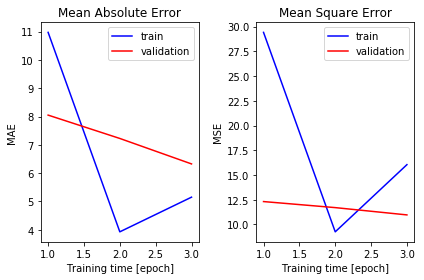

In [9]:
# Plot MAE and MSE during training

plt.subplot(121) # MAE
plt.plot(np.linspace(1,epochs,epochs),trainMAE,'b',label='train')
plt.plot(np.linspace(1,epochs,epochs),validateMAE,'r',label='validation')
plt.xlabel('Training time [epoch]')
plt.ylabel('MAE')
plt.legend(['train','validation'])
plt.title('Mean Absolute Error')

plt.subplot(122) # MSE
plt.plot(np.linspace(1,epochs,epochs),trainMSE,'b',label='train')
plt.plot(np.linspace(1,epochs,epochs),validateMSE,'r',label='validation')
plt.xlabel('Training time [epoch]')
plt.ylabel('MSE')
plt.legend(['train','validation'])
plt.title('Mean Square Error')
plt.tight_layout()
plt.savefig(path+'/Results/graphs.png')
plt.show()




In [10]:
       
### TEST SESSION ###
init = tf.global_variables_initializer()
imgsTest,labelsTest = importImages(4,5)
savePath = path+'/Results/'
with tf.Session() as sess:
    sess.run(init)
    result = evaluateNetwork(imgsTest)
    np.savetxt(savePath+"feedforward.csv", result, delimiter=",")
    np.savetxt(savePath+"ffGT.csv", labelsTest, delimiter=",")